In [4]:
using NNPoly, NeuralVerification, LazySets, Flux, Plots
const NP = NNPoly
const NV = NeuralVerification

NeuralVerification

# Demo of NNPoly

In this demo notebook, we revisit the small example network from the paper and also apply PolyCROWN to a larger MNIST network.

Julia precompiles the code once it is executed the first time. Therefore the first execution of a code cell might be slow. The second execution, however, should be much faster.

# Utility Functions

First, we define some utility functions for plotting the polynomial symbolic bounds and the ReLU relaxations.

In [45]:
function get_output_polys(net, α, solver, input_set)
    α = copy(α)
    # setup precomputed values
    s = NP.initialize_symbolic_domain(solver, net[1:1], input_set)
    ŝ, lbs, ubs, rs, cs, symmetric_factor, unique_idxs, duplicate_idxs = NP.initialize_params_bounds(solver, net, 2, s)
    
    # change params to the optimized monomial coefficients
    net[1].α .= α
    
    s_poly = NP.forward_act_stub(solver.poly_solver, net[1], ŝ, lbs[1], ubs[1], rs, cs, symmetric_factor, unique_idxs, duplicate_idxs)
    s_crown = NV.forward_network(solver.lin_solver, net[2:end], s_poly, lbs[2:end], ubs[2:end])
    
    L, _ = NP.interval_map_common(min.(0, s_crown.Λ), max.(0, s_crown.Λ), s_poly.poly_interval.Low, s_poly.poly_interval.Up, s_crown.λ)
    _, U = NP.interval_map_common(min.(0, s_crown.Γ), max.(0, s_crown.Γ), s_poly.poly_interval.Low, s_poly.poly_interval.Up, s_crown.γ)

    return s_poly, L, U
end

get_output_polys (generic function with 1 method)

In [28]:
"""
Plots polynomial ReLU relaxations and output symbolic intervals for parameters stored in net and obtained lbs, ubs on the neurons' input.

kwargs:
    p - subplots to add to (if empty, then generate new subplots)
    label - label to attach to plotted lines
"""
function plot_polynomials(solver, net, input_set, lbs, ubs, ps=[]; label="", linestyle=:auto)
    cₗ = NP.get_lower_polynomial_shift(lbs[1], ubs[1], 2, net[1].α[:,:,1])
    cᵤ = NP.get_upper_polynomial_shift(lbs[1], ubs[1], 2, net[1].α[:,:,2])

    if isempty(ps)
        p1 = plot(title="ReLU(n̂₁)")
        p2 = plot(title="ReLU(n̂₂)")
        p3 = plot(title="y")
    else
        p1, p2, p3 = ps
    end 

    idx = 1
    xs = lbs[1][idx]:0.01:ubs[1][idx]
    lp = x -> cₗ[idx,:]' * [1, x, x^2]
    up = x -> cᵤ[idx,:]' * [1, x, x^2]
    plot!(p1, xs, lp.(xs), label="lower " * label, linestyle=linestyle)
    plot!(p1, xs, up.(xs), label="upper " * label, linestyle=linestyle)

    idx = 2
    xs = lbs[1][idx]:0.01:ubs[1][idx]
    lp = x -> cₗ[idx,:]' * [1, x, x^2]
    up = x -> cᵤ[idx,:]' * [1, x, x^2]
    plot!(p2, xs, lp.(xs), label="lower " * label, linestyle=linestyle)
    plot!(p2, xs, up.(xs), label="upper " * label, linestyle=linestyle)

    s_poly, L, U = get_output_polys(net, net[1].α, solver, input_set)
    xs = low(input_set)[1]:0.01:high(input_set)[1]
    plot!(p3, xs, [NP.evaluate(L, x)[1] for x in xs], label="lower " * label, linestyle=linestyle)
    plot!(p3, xs, [NP.evaluate(U, x)[1] for x in xs], label="upper " * label, linestyle=linestyle)

    return p1, p2, p3
end

plot_polynomials

## Example Network

We run PolyCROWN and (for demonstration purposes our own implementation of) $\alpha$-CROWN on the example network given in the paper.

First, we define the network -- one with learnable parameters for the monomial coefficients in case of PolyCROWN, the other with learnable parameters for the slopes of the linear lower relaxations in case of $\alpha$-CROWN.

In [5]:
W1 = reshape([1.; 1], 2, 1)  # need matrix
b1 = [0.5, -0.5]
W2 = [1 -1.]
b2 = [0.]

L1 = NP.CROWNLayer(W1, b1, NV.ReLU(), zeros(2, 2, 2))
L2 = NP.CROWNLayer(W2, b2, NV.Id(), similar(b2, 0))
net_pcrown = Chain(L1, L2)

L1 = NP.CROWNLayer(W1, b1, NV.ReLU(), similar(b1))
L2 = NP.CROWNLayer(W2, b2, NV.Id(), similar(b2, 0))
net_acrown = Chain(L1, L2)

Chain(
  NNPoly.CROWNLayer{NeuralVerification.ReLU, Matrix{Float64}, Vector{Float64}, Vector{Float64}}([1.0; 1.0;;], [0.5, -0.5], NeuralVerification.ReLU(), [0.0, 7.1e-322]),  # 2 parameters, plus 4
  NNPoly.CROWNLayer{NeuralVerification.Id, Matrix{Float64}, Vector{Float64}, Vector{Float64}}([1.0 -1.0], [0.0], NeuralVerification.Id(), Float64[]),  # 0 parameters, plus 3  (all zero)
) 

We want to find a tight upper bound on the output of the network for inputs $x \in [-1, 1]$.

In [6]:
input_set = Hyperrectangle(low=[-1.], high=[1.])

Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([0.0], [1.0])

We instantiate the PolyCROWN solver. 

`DiffNNPolySym` (for differentiable, neural network and polynomial symbolic intervals) is just the name of our implementation of forward propagation of the polynomial relaxations through the first layer of the network.

In [7]:
# need to turn off pruning, otherwise, we copy the NN and then can't observe the changed params
solver = NP.PolyCROWN(NP.DiffNNPolySym(common_generators=true), prune_neurons=false)

NNPoly.PolyCROWN
  separate_alpha: Bool true
  use_tightened_bounds: Bool true
  prune_neurons: Bool false
  poly_layers: Int64 1
  poly_solver: NNPoly.DiffNNPolySym
  lin_solver: NNPoly.aCROWN


For illustration purposes, we show the result of the overapproximation with the initial parameters (note the `n_steps=0` in the `NP.OptimisationParams`).

The initial parameters are the initial values for the monomial coefficients of the polynomial relaxations.

In [46]:
params = NP.OptimisationParams(n_steps=0, timeout=120., print_freq=25, y_stop=0., save_ys=true, save_times=true, start_lr=0.1, decay=0.98)

t = @elapsed res, lbs_pcrown, ubs_pcrown = NP.optimise_bounds(solver, net_pcrown, input_set, params=params, loss_fun=NP.violation_loss, print_results=true)

lbs = [-0.5]
ubs = [1.5]


0.0251447

Using the initial relaxation, we have guaranteed bounds on the output $y$ of the network of $y \in [-0.5, 1.5]$.

We can also plot the polynomial relaxations of the 2 ReLU activations in the NN and also plot the symbolic polynomial lower and upper bounds on the output of the NN.

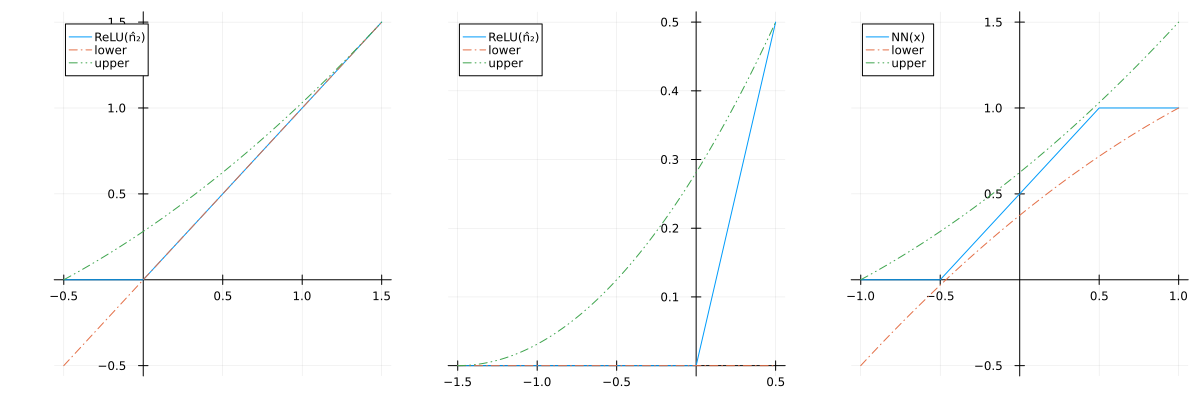

In [47]:
xs = lbs_pcrown[1][1]:0.01:ubs_pcrown[1][1]
p1 = plot(xs, max.(0, xs), label="ReLU(n̂₂)", framestyle=:origin)

xs = lbs_pcrown[1][2]:0.01:ubs_pcrown[1][2]
p2 = plot(xs, max.(0, xs), label="ReLU(n̂₂)", framestyle=:origin)

xs = low(input_set)[1]:0.01:high(input_set)[1]
p3 = plot(xs, net_pcrown(xs')', label="NN(x)", framestyle=:origin)

p1, p2, p3 = plot_polynomials(solver, net_pcrown, input_set, lbs_pcrown, ubs_pcrown, [p1, p2, p3], label="", linestyle=:auto)
plot(p1, p2, p3, layout=grid(1, 3), size=(1200, 400))

Now we want to find a smaller, but still valid upper bound, by optimizing the monomial coefficients of the polynomial ReLU relaxations.

In [48]:
params = NP.OptimisationParams(n_steps=1000, timeout=120., print_freq=25, y_stop=0., save_ys=true, save_times=true, start_lr=0.1, decay=0.98)

t = @elapsed res, lbs_pcrown, ubs_pcrown = NP.optimise_bounds(solver, net_pcrown, input_set, params=params, loss_fun=NP.violation_loss, print_results=true)

25: 1.1303434825439238
50: 1.039739890962516
75: 1.016173524095961
100: 1.0230956704617482
125: 1.0178409620228577
150: 1.0185696900755512
175: 1.0166765298828007
200: 1.0144284111455606
225: 1.0147406190616182
250: 1.014112198567823
275: 1.014172080587817
No improvement over the last 50 iterations. Stopping early.
lbs = [-0.5]
ubs = [1.0138502198592203]


2.3671831

The optimisation successfully found an upper bound of $y \leq 1.0139$, improving upon the bound of $1.5$ obtained from the initial relaxation.

We can also see in the subplot on the left, that this concrete upper bound is very close to the true maximum of the NN over the input domain.

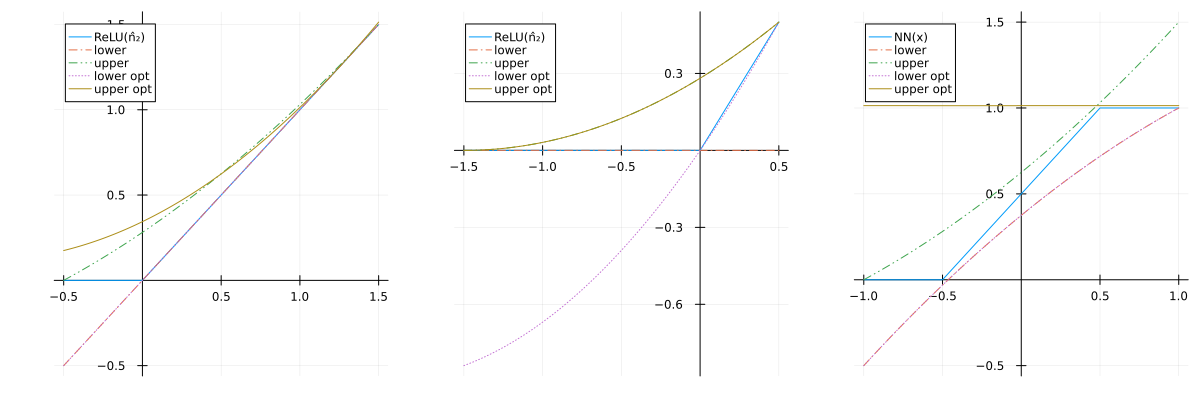

In [49]:
p1, p2, p3 = plot_polynomials(solver, net_pcrown, input_set, lbs_pcrown, ubs_pcrown, [p1, p2, p3], label="opt", linestyle=:auto)
plot(p1, p2, p3, layout=grid(1, 3), size=(1200, 400))

In [53]:
params = NP.OptimisationParams(n_steps=1000, timeout=120., print_freq=25, y_stop=0., save_ys=true, save_times=true, start_lr=0.1, decay=0.98)

solver = NP.aCROWN()
t = @elapsed res, lbs_acrown, ubs_acrown = NP.optimise_bounds(solver, net_acrown, input_set, params=params, loss_fun=NP.violation_loss)

@show lbs_acrown[end]
@show ubs_acrown[end];

25: 1.1578372373912402
50: 1.128719632810905
75: 1.127341472806621
100: 1.1289649982592005
125: 1.126673840507056
No improvement over the last 50 iterations. Stopping early.
lbs_acrown[end] = [-0.5]
ubs_acrown[end] = [1.125001367316537]


Optimizable linear relaxations only achieve a verified upper bound of $y \leq 1.125$, which is not as tight as the upper bound of $\approx 1.0139$ that we saw above.

# MNIST

The main factor limiting scalability is not the size of the network, but the number of unfixed input dimensions.

An important property in neural network verification that requires reasoning over an intermediate number of unfixed input dimensions is robustness against adversarial patches.

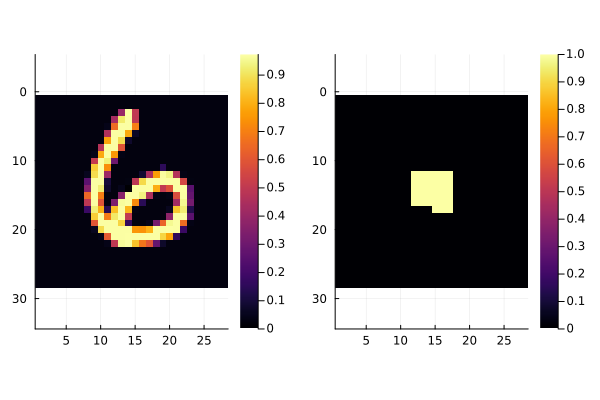

In [88]:
net_path = "./eval/mnist_fc/onnx/mnist-net_256x4.onnx"
vnnlib_path = "./eval/mnist_fc/vnnlib/prop_14_spiral_33.vnnlib"

vnnlib_path_plot = "./eval/mnist_fc/vnnlib/prop_14_spiral_1.vnnlib"

rv = NP.read_vnnlib_simple(vnnlib_path, 784, 10);
specs = NP.generate_specs(rv);
input_set, output_set = specs[1]

rv = NP.read_vnnlib_simple(vnnlib_path_plot, 784, 10);
specs = NP.generate_specs(rv);
input_set_plot, output_set_plot = specs[1]

p1 = heatmap(reshape(low(input_set_plot), 28, 28)', yflip=true, aspect_ratio=:equal)

img_mask_low = reshape(low(input_set), 28, 28)'
img_mask_high = reshape(high(input_set), 28, 28)'
img_mask = img_mask_low .!= img_mask_high

p2 = heatmap(img_mask', yflip=true, aspect_ratio=:equal)

plot(p1, p2)

Specifically, we want to prove that the image on the left will still be classified as `6`, even if the pixels within the mask shown on the right can take arbitrary values between $0$ and $1$.

First, we load the network and convert it to our internal representation with learnable parameters for the monomial coefficients of the relaxation in the first layer (`first_layer_degree=2`) and learnable linear slope parameters in the remainder of the layers (`degree=1`).

We add a dummy output layer to be able to directly merge the specification ($y_i - y_6 \leq 0, ~\forall i \neq 6$) into the last layer.

In [90]:
mnist_pcrown = NP.onnx2CROWNNetwork(net_path, dtype=Float64, degree=1, first_layer_degree=2, add_dummy_output_layer=true)
mnist_pcrown_merged = NP.merge_spec_output_layer(mnist_pcrown, output_set)

Chain(
  NNPoly.CROWNLayer{NeuralVerification.ReLU, Matrix{Float64}, Vector{Float64}, Array{Float64, 3}}([-0.04673020541667938 0.05469107627868652 … 0.015739239752292633 0.07382158935070038; -0.06301576644182205 -0.06443489342927933 … -0.07172191888093948 -0.07134305685758591; … ; 0.029313579201698303 0.035903386771678925 … 0.055924415588378906 -0.009606853127479553; -0.001448117196559906 -0.03438897430896759 … 0.002958424389362335 0.032731182873249054], [0.0855686292052269, -0.13010096549987793, -0.057506732642650604, -0.10592808574438095, 0.05324007570743561, 0.08116327226161957, -0.04294257611036301, 0.06134471669793129, -0.12583771347999573, -0.049272362142801285  …  0.08016236871480942, -0.13416247069835663, 0.024397389963269234, -0.1696905940771103, -0.049506887793540955, -0.00097083201399073, -0.06181824207305908, -0.029777919873595238, 0.0032220862340182066, 0.0636550709605217], NeuralVerification.ReLU(), [0.0 0.0; 0.0 0.0037264188672455696; … ; 0.0016585680372298598 -0.0; 0.0 

Then we optimize the parameters of our relaxations just as in the example above.

The violation loss we optimize is just $\sum_{i \neq 6} \max(0, y_i - y_6)$.
If that loss is equal to $0$, we have successfully proven, that $y_6$ is the largest output over the whole input domain and thus all images over that domain will be classified as $6$.

In [91]:
solver = NP.PolyCROWN(NP.DiffNNPolySym(common_generators=true), prune_neurons=true)
params = NP.OptimisationParams(print_freq=10, timeout=60, n_steps=200, save_ys=false, y_stop=0)

res, lbs_pcrown, ubs_pcrown = NP.optimise_bounds(solver, mnist_pcrown_merged, input_set, params=params, loss_fun=NP.violation_loss, print_results=true);

10: 20.850800291340352
20: 13.276823951933165
30: 8.992866036109152
40: 6.532720314245142
50: 2.8596415041464107
60: 0.8307218558450565
70: 0.024970774109807983
74: Stopping criterion reached! y = 0.0 ≤ 0.0
lbs = [-1.3847676440210948, -1.437602729729857, -1.3847676440210948, -1.3847676440210948, -1.3847676440210948, -1.3847676440210948, -1.415738021235173, -1.3847676440210948, -1.3847676440210948]
ubs = [-0.03791181980251459, -0.09288637017528448, -0.04771103497537591, -0.09443094582959624, -0.06587589135459995, -0.029969671775368897, -0.10640828865998686, -0.005690692832758736, -0.094136927058985]


In [93]:
solver = NP.aCROWN()
params = NP.OptimisationParams(print_freq=25, timeout=300, n_steps=1000)
mnist_acrown = NP.onnx2CROWNNetwork(net_path, dtype=Float64)
mnist_acrown_merged = NP.merge_spec_output_layer(mnist_acrown, output_set)
t = @elapsed res, lbs_crown, ubs_crown = NP.optimise_bounds(solver, mnist_acrown_merged, input_set, params=params)


25: 134.5734102311796
50: 124.99369185132403
75: 117.88331952868859
100: 111.25610631668711
125: 105.08369271097357
150: 99.40130793489396
175: 94.21931354289708
